# Import Library

In [1]:
from __future__ import print_function #향후에 어떤 파이썬 버전을 쓰더라도 파이썬3 문법 print()를 사용하겠다고 선언
import argparse #다양한 형식으로 인수 지정 가능
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms #data from pytorch
from torch.autograd import Variable #Variable 클래스는 각 tensor의 값을 볼 수 있는 data, 미분을 보는 grad, backward를 통한 미분을 계산한 함수 정보인 grad_fn 총 3개의 함수로 이루어진다.
#자동미분을 위해 만들어졌다. 하지만 현재는 torch에서 모든 tensor에 autograd가 가능하도록 설정되어있다.

from torch.utils import data
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Baseline

In [2]:
batch_size = 64

#MNIST Dataset
train_dataset = datasets.MNIST(root='../data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = datasets.MNIST(root='../data',train=False,transform=transforms.ToTensor(),download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
len(train_dataset),len(test_dataset) #train: 60000 data, test: 10000data

(60000, 10000)

In [4]:
train_dataset[0][0].shape #image input size = 28*28

torch.Size([1, 28, 28])

In [5]:
#MNIST Input image size = 28*28
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()                   
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5) #input_channel_size =1, output_volume_size = 10(몇 장의 필터 생성)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 5) #input_channel_size =10, output_volume_size = 20
        self.mp = nn.MaxPool2d(2) #kernel_size = 2, Maxpool2d(2,2)와 동일 stride = kernel_size(default)
        self.fc = nn.Linear(320,10) #input_size = 20 * 4 * 4
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        #output size = 10 * 24 * 24(conv1)
        #output size = 10 * 12 * 12(maxpooling)
        x = F.relu(self.mp(self.conv2(x)))
        #output size = 20 * 8 * 8(conv2)
        #output size = 20 * 4 * 4(maxpooling)
        x = x.view(in_size, -1) #flatten (1차원)
        x = self.fc(x) #Linear
        return F.log_softmax(x)

In [6]:
model = Net()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)

In [7]:
def train(epoch):
    model.train() #train mode진입(dropout = True)
    for batch_idx, (data,target) in enumerate(train_loader): #batch_size만큼 data 뽑아냄.
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() #gradient 초기화
        output = model(data) #forward 계산
        loss = F.nll_loss(output, target) #loss계산
        loss.backward() #역전파 
        optimizer.step() #parameter update
        if batch_idx % 10 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data 
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
for epoch in range(1, 10):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308792
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301495
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.288147
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.281963
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.271379
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.251936
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.258652
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211991
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.179695
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.124492
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.020154
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.881106
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.665710
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.554863
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.208739
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.002465
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.719336
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.963860
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.584383
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.544823
Train Epoch: 1 [12800/60000 (

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1904, Accuracy: 9429/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228744
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.165970
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.129444
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.256035
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.138372
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.162272
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.156043
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.315024
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.157875
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.211650
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.102458
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.093930
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.203284
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.229160
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.114388
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.246001
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.394007
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.218838
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.304424
Train Epoch: 2 [12

# Task1

In [10]:
#MNIST Input image size = 28*28 (channel = 1)
class revised_Net(nn.Module):
    def __init__(self):
        super(revised_Net,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size = 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size = 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3, padding=1, stride=1)
        self.mp1 = nn.MaxPool2d(kernel_size = 2)
        self.mp2 = nn.MaxPool2d(kernel_size = 2,padding = 1)
        self.fc1 = nn.Linear(2048,100) #128*4*4
        self.fc2 = nn.Linear(100,10)
        
    def forward(self,x): #x:input
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1(x)))
        #output size = 32 * 28 * 28(conv1)
        #output size = 32 * 14 * 14(mp1)
        x = F.relu(self.mp1(self.conv2(x)))
        #output size = 64 * 14 * 14(conv2)
        #output size = 64 * 7 * 7(mp1)
        x = F.relu(self.mp2(self.conv3(x)))
        #output size = 128 * 7 * 7(conv3)
        #output size = 128 * 4 * 4(mp2)
        x = x.view(in_size,-1) #flatten(1차원화) for fully-connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
model = revised_Net()
optimizer = optim.SGD(model.parameters(),lr = 0.01, momentum = 0.5) #momentum: 이전에 학습했던 속도를 반영 

def train(epoch):
    model.train() 
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() #gradient 초기화
        output = model(data) #forward 계산
        loss = F.nll_loss(output, target) #Negative log likelihood loss
        #CrossEntropyLoss = LogSoftmax(softmax에 log취함) + NLLLoss(log결과값에 대한 CrossEntropyLoss|Error)
        loss.backward() #역전파 
        optimizer.step() #parameter update
        if batch_idx % 10 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target) 
        #volatile = True: only forward, no backpropagation(test이므로 역전파 필요 X)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data 
        #size_average = False: loss가 each minibatch마다 계속 sum된다 >> 나중에 총 테스트 셋으로 나눠서 평균구해주기 위해
        #True면 each batch마다의 평균을 보여준다.
        pred = output.data.max(1, keepdim=True)[1]
        #keepdim = True: pred의 텐서 사이즈 output과 똑같이 유지 
        #max함수 안의 1은 어느 방향으로 max값 찾을지의 의미
        #출력된 max는 (값,인덱스). [1]을 사용해 index출력 = label
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        #eq: torch요소별 동등성 계산 (pred, target.data.view_as(pred))
        #view_as는 input과 똑같은 사이즈로 토치를 정렬한다(위에서는 target을 pred와 똑같은 사이즈로 torch 정렬)
        # correct = 동일한 요소의 개수를 sum 한 것

    test_loss /= len(test_loader.dataset) #전체 평균 loss: 전체 테스트 셋으로 나눠준다.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
for epoch in range(1,10):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309402
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302801
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.303683
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.296915
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.298002
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.295329
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.301743
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.304991
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.303972
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.305645
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.299156
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.297125
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.297316
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.298427
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.284627
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.287691
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.287148
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.295253
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.284372
Train Epoch: 1 [12800/60000 (

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  



Test set: Average loss: 0.2839, Accuracy: 9101/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.351563
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.310202
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.291935
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.316669
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.165852
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.407812
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.333447
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.291019
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.211198
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.291827
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.494667
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.210485
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.213714
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.301591
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.257882
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.230258
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.168636
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.250914
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.376473
Train Epoch: 2 [12

# Task2

베이스라인 마음대로 변경 + Softmax regression 과제에서 사용했던 데이터셋 (변경 가능하나 같은 데이터셋으로 진행하시는 걸 추천드립니다!) >> CNN으로 성공해보자!

지난번 과제와 마찬가지로 다양한 방식을 시도해보시고 그 시도 기록을 남겨주세요. 가장 성능이 좋았던 모델도 표시 부탁드립니다!

이번엔 GPU resource 문제가 생길 수 있습니다. 파라미터 조정, dropout 추가 등 연산 효율성도 고려해서 베이스라인 조정해보세요!

DTD image 설명

1. 5640 images, 47 categories, 120 images for each category.
1. Image size range between 300*300 and 640*640
1. images contain at least 90% of the surface representing the category attribute

In [14]:
#GPU할당을 위한 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [15]:
device

'cuda'

In [16]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [17]:
#이미지 사이즈 조정후(64*64 으로 통일) 텐서로 변환
dtd_train = datasets.DTD(
    root="../data", split='train', transform = train_transform, download=True)
dtd_test = datasets.DTD(
    root="../data", split='test', transform = test_transform, download=True)

  0%|          | 0/625239812 [00:00<?, ?it/s]

Extracting ../data/dtd/dtd-r1.0.1.tar.gz to ../data/dtd


In [18]:
#이미지 정규화를 위해 함수를 만든다.
def get_mean_std(dataset):
    #train의 각 image의 RGB채널별 픽셀값들의 평균, 표준편차(1880개의 Image)
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])
    
    mean = [meanR,meanG,meanB]
    std = [stdR,stdG,stdB]
    
    return mean,std

In [19]:
#적절한 데이터 양을 만들기 위해 이미지를 64*64 size로 통일한다.
dtd_train.transform = transforms.Compose([
    transforms.Resize((100,100)), #이미지 크기 조정(conv층 통과하기 위함)
    transforms.RandomResizedCrop(64),  #데이터 확장 용도. 이미지 랜덤 비율로 자름.
    transforms.ToTensor(),
    transforms.Normalize(get_mean_std(dtd_train)[0], get_mean_std(dtd_train)[1])
    ])

dtd_test.transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(get_mean_std(dtd_test)[0], get_mean_std(dtd_test)[1])
    ]) #mean, std

In [20]:
batch_size = 12

train_loader = data.DataLoader(dtd_train, batch_size=batch_size,
                                          shuffle=True)
test_loader = data.DataLoader(dtd_test, batch_size=batch_size,
                                          shuffle=True)

In [21]:
len(dtd_train),len(dtd_test) #train: 1880, test: 1880

(1880, 1880)

In [22]:
print(dtd_train.classes) #47 classes
classes = dtd_train.classes

['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']


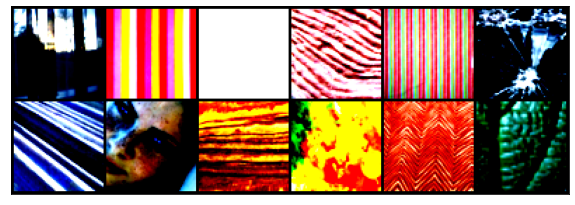

In [23]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (10,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images,nrow=6).permute(1,2,0))
        break
        
show_batch(train_loader)

In [24]:
for X,y in train_loader:  #X: image, Y:label index
    print(X.shape,X.dtype,y.shape,y.dtype)
    break

torch.Size([12, 3, 64, 64]) torch.float32 torch.Size([12]) torch.int64


# Model

# # Model1  
baseline에서 만든 모델과 거의 유사한 모델

기존 최고 성능 acc: 10%

08.01. 01:47 batchnorm2d 추가 - 배치 단위별로 데이터가 다양한 분포 가져도 평균과 분산 이용해 정규화 >> 성능 더 떨어짐(2%)

08.01 02:13 이미지 전체 정규화(평균, 표준편차 계산): 성능이 오히려 더 떨어지는 모습
loss값이 왔다갔다 한다. >> learning rate를 조절해보자

08.01 12:00 Adam parameter 조정

In [25]:
class Model_norm(nn.Module):
    def __init__(self):
        super(Model_norm,self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size = 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size = 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3, padding=1, stride=1)
        
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.norm3 = nn.BatchNorm2d(128)
        
        self.mp = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 8192,out_features= 100) #128*29*29
        self.fc2 = nn.Linear(in_features = 100,out_features= 47) #마지막 output: class개수
        
    def forward(self,x): #x:input
        in_size = x.size(0)
        x = F.relu(self.mp(self.norm1(self.conv1(x))))
        #output size = 32 * 224 * 224(conv1)
        #output size = 32 * 112 * 112(mp1)
        x = F.relu(self.mp(self.norm2(self.conv2(x))))
        #output size = 64 * 112 * 112(conv2)
        #output size = 64 * 56 * 56(mp1)
        x = F.relu(self.mp(self.norm3(self.conv3(x))))
        #output size = 128 * 56* 56(conv3)
        #output size = 128 * 28 * 28(mp2)
        
        x = x.view(in_size,-1) #flatten(1차원화) for fully-connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

batchNorm을 걸어주면 이상하게도 학습이 잘 되지 않는다!

In [26]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size = 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size = 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3, padding=1, stride=1)
        
        self.mp = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 8192,out_features= 100) #128*29*29
        self.fc2 = nn.Linear(in_features = 100,out_features= 47) #마지막 output: class개수
        
    def forward(self,x): #x:input
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        #output size = 32 * 64 * 64(conv1)
        #output size = 32 * 32 * 32(mp1)
        x = F.relu(self.mp(self.conv2(x)))
        #output size = 64 * 32 * 32(conv2)
        #output size = 64 * 16 * 16(mp1)
        x = F.relu(self.mp(self.conv3(x)))
        #output size = 128 * 16* 16(conv3)
        #output size = 128 * 8 * 8(mp2)
        
        x = x.view(in_size,-1) #flatten(1차원화) for fully-connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

batchnorm을 빼면 어느정도 학습이 된다. acc = 10%

### 가중치 초기화

In [27]:
def init_weights(layer): #가중치 초기화
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01) #편차 초기화

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [28]:
model = Model_norm().to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr = 0.0005) #momentum: 이전에 학습했던 속도를 반영 
#optimizer는 지난 주 과제에서 가장 성능이 좋았던 Adam을 사용.


def train(epoch):
    model.train() 
    train_loss = 0
    correct = 0
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data) #forward 계산
        loss = F.nll_loss(output, target) #Negative log likelihood loss
        #CrossEntropyLoss = LogSoftmax(softmax에 log취함) + NLLLoss(log결과값에 대한 CrossEntropyLoss|Error)
        
        
        optimizer.zero_grad() #gradient 초기화
        loss.backward() #역전파 
        optimizer.step() #parameter update
        
        if batch_idx % 40 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [29]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #Varaiable volatile=True가 deprecated되어서 대체하였습니다.
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            #volatile = True: only forward, no backpropagation(test이므로 역전파 필요 X)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data 
            #size_average = False: loss가 each minibatch마다 계속 sum된다 >> 나중에 총 테스트 셋으로 나눠서 평균구해주기 위해
            #True면 each batch마다의 평균을 보여준다.
            pred = output.data.max(1, keepdim=True)[1]
            #keepdim = True: pred의 텐서 사이즈 output과 똑같이 유지 
            #max함수 안의 1은 어느 방향으로 max값 찾을지의 의미
            #출력된 max는 (값,인덱스). [1]을 사용해 index출력 = label
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            #eq: torch요소별 동등성 계산 (pred, target.data.view_as(pred))
            #view_as는 input과 똑같은 사이즈로 토치를 정렬한다(위에서는 target을 pred와 똑같은 사이즈로 torch 정렬)
            # correct = 동일한 요소의 개수를 sum 한 것

    test_loss /= len(test_loader.dataset) #전체 평균 loss: 전체 테스트 셋으로 나눠준다.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [30]:
for epoch in range(1,10):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/1880 (0%)]	Loss: 4.824228
Train Epoch: 1 [480/1880 (25%)]	Loss: 3.931259
Train Epoch: 1 [960/1880 (51%)]	Loss: 3.800878
Train Epoch: 1 [1440/1880 (76%)]	Loss: 3.848953

Test set: Average loss: 3.8502, Accuracy: 40/1880 (2%)

Train Epoch: 2 [0/1880 (0%)]	Loss: 3.850373
Train Epoch: 2 [480/1880 (25%)]	Loss: 3.849121
Train Epoch: 2 [960/1880 (51%)]	Loss: 3.850316
Train Epoch: 2 [1440/1880 (76%)]	Loss: 3.850153

Test set: Average loss: 3.8502, Accuracy: 40/1880 (2%)

Train Epoch: 3 [0/1880 (0%)]	Loss: 3.849489
Train Epoch: 3 [480/1880 (25%)]	Loss: 3.849876
Train Epoch: 3 [960/1880 (51%)]	Loss: 3.848459
Train Epoch: 3 [1440/1880 (76%)]	Loss: 3.852427

Test set: Average loss: 3.8502, Accuracy: 40/1880 (2%)

Train Epoch: 4 [0/1880 (0%)]	Loss: 3.850026
Train Epoch: 4 [480/1880 (25%)]	Loss: 3.850047
Train Epoch: 4 [960/1880 (51%)]	Loss: 3.849933
Train Epoch: 4 [1440/1880 (76%)]	Loss: 3.851671

Test set: Average loss: 3.8502, Accuracy: 40/1880 (2%)

Train Epoch: 5 [0/1880 (0%)]

성능이 10%를 넘지 못한다

## Model2
activation으로 leakyrelu사용
Conv 개수를 늘려보자 3>> 5 <br>
FCN 개수도 2>>3 <br>

2%의 암울한 성능. CNN 망을 늘리는게 능사가 아니다. 학습이 잘 되고 있지 않다.

이미지 정규화 이후 다시 모델을 돌려보았더니, 12%의 accuracy가 나오게 되었다

In [31]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2,self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(32,64,kernel_size = 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64,128,kernel_size = 3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(128,256,kernel_size = 3, padding=1, stride=1)
        self.mp = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 1024,out_features= 300) # 256 * 7* 7
        self.fc2 = nn.Linear(in_features = 300,out_features= 100) 
        self.fc3 = nn.Linear(in_features = 100,out_features= 47) #마지막 output: class개수
        
    def forward(self,x): #x:input
        in_size = x.size(0)
        x = F.leaky_relu(self.mp(self.conv1(x)))
        #output size = 16 * 64 * 64(conv1)
        #output size = 16 * 32 * 32(mp)
        x = F.leaky_relu(self.mp(self.conv2(x)))
        #output size = 32 * 32 * 32(conv2)
        #output size = 32 * 16 * 16(mp)
        x = F.leaky_relu(self.mp(self.conv3(x)))
        #output size = 64 * 16* 16(conv3)
        #output size = 64 * 8 * 8(mp)
        x = F.leaky_relu(self.mp(self.conv4(x)))
        #output size = 128 * 8* 8(conv3)
        #output size = 128 * 4* 4(mp)
        x = F.leaky_relu(self.mp(self.conv5(x)))
        #output size = 256 * 4* 4(conv3)
        #output size = 256 * 2* 2(conv3)
        x = x.view(in_size,-1) #flatten(1차원화) for fully-connected layer
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [32]:
model = Model().to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr = 0.001) #momentum: 이전에 학습했던 속도를 반영 

def train(epoch):
    model.train() 
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad() #gradient 초기화
        output = model(data) #forward 계산
        loss = F.nll_loss(output, target) #Negative log likelihood loss
        #CrossEntropyLoss = LogSoftmax(softmax에 log취함) + NLLLoss(log결과값에 대한 CrossEntropyLoss|Error)
        loss.backward() #역전파 
        optimizer.step() #parameter update
        if batch_idx % 100 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [33]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #Varaiable volatile=True가 deprecated되어서 대체하였습니다.
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            #volatile = True: only forward, no backpropagation(test이므로 역전파 필요 X)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data 
            #size_average = False: loss가 each minibatch마다 계속 sum된다 >> 나중에 총 테스트 셋으로 나눠서 평균구해주기 위해
            #True면 each batch마다의 평균을 보여준다.
            pred = output.data.max(1, keepdim=True)[1]
            #keepdim = True: pred의 텐서 사이즈 output과 똑같이 유지 
            #max함수 안의 1은 어느 방향으로 max값 찾을지의 의미
            #출력된 max는 (값,인덱스). [1]을 사용해 index출력 = label
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            #eq: torch요소별 동등성 계산 (pred, target.data.view_as(pred))
            #view_as는 input과 똑같은 사이즈로 토치를 정렬한다(위에서는 target을 pred와 똑같은 사이즈로 torch 정렬)
            # correct = 동일한 요소의 개수를 sum 한 것

    test_loss /= len(test_loader.dataset) #전체 평균 loss: 전체 테스트 셋으로 나눠준다.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [34]:
for epoch in range(1,10):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/1880 (0%)]	Loss: 3.919979
Train Epoch: 1 [1200/1880 (64%)]	Loss: 3.857032

Test set: Average loss: 3.8350, Accuracy: 44/1880 (2%)

Train Epoch: 2 [0/1880 (0%)]	Loss: 3.783566
Train Epoch: 2 [1200/1880 (64%)]	Loss: 3.844994

Test set: Average loss: 3.7870, Accuracy: 54/1880 (3%)

Train Epoch: 3 [0/1880 (0%)]	Loss: 3.495287
Train Epoch: 3 [1200/1880 (64%)]	Loss: 3.826782

Test set: Average loss: 3.7465, Accuracy: 95/1880 (5%)

Train Epoch: 4 [0/1880 (0%)]	Loss: 3.516754
Train Epoch: 4 [1200/1880 (64%)]	Loss: 3.642861

Test set: Average loss: 3.7134, Accuracy: 108/1880 (6%)

Train Epoch: 5 [0/1880 (0%)]	Loss: 3.801678
Train Epoch: 5 [1200/1880 (64%)]	Loss: 3.891858

Test set: Average loss: 3.6839, Accuracy: 148/1880 (8%)

Train Epoch: 6 [0/1880 (0%)]	Loss: 3.485755
Train Epoch: 6 [1200/1880 (64%)]	Loss: 4.123987

Test set: Average loss: 3.6568, Accuracy: 159/1880 (8%)

Train Epoch: 7 [0/1880 (0%)]	Loss: 3.406759
Train Epoch: 7 [1200/1880 (64%)]	Loss: 3.522132

Test set: 

# Model 3 (최고성능)
Conv layer를 쌓으면 오히려 성능이 떨어져서 
가장 간단한 CNN인 LeNet을 차용해보자<br>
9%의 성능 이제까지 한 것 중 나쁘지 않다..<br>
batchnorm 추가시 epoch마다 acc가 왔다갔다 하는 경향이 있음

08-01 14:54 batch_size를 50으로 증겨시켜보았다. lr = 0.1*batch_size/256으로 정의 <br>
https://medium.com/curg/딥러닝-성능을-높이기-위한-다양한-꿀팁들-1910c6c7094a

08-01 15:37 image size를 다시 224*224로 재조정. centeredcrop 사용

08-01 16:38 image size 다시 64*64 재조정. train,test image 모두 normalization 진행 >>최고성능 <br>
adam 0.0001 : 210 / 1880(epoch 10 기준) <br>
adam 0.0005 : 231 / 1880 <br>


optimizer: Adam, learning_rate = 0.0005로 고정 >> 최고 acc: 270/1880(14%)

In [35]:
class LeNet(nn.Module): #최고성능모델
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,kernel_size = 5, padding=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size = 5)
        
#         self.norm1 = nn.BatchNorm2d(6) #batch normalization 
#         self.norm2 = nn.BatchNorm2d(16)
        
        self.mp = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(in_features = 3136,out_features= 1000) 
        self.fc2 = nn.Linear(in_features = 1000,out_features= 100) 
        self.fc3 = nn.Linear(in_features = 100,out_features= 47) #최종 output: class개수
        
    def forward(self,x): #x:input
        in_size = x.size(0)
        x = self.mp(F.leaky_relu(self.conv1(x)))
        #output size = 6 * 64 * 64(conv1)
        #output size = 6 * 32 * 32(mp)
        x = self.mp(F.leaky_relu(self.conv2(x)))
        #output size = 16 * 28 * 28(conv2)
        #output size = 16 * 14 * 14(mp)
        
        x = x.view(in_size,-1) #flatten(1차원화) for fully-connected layer
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [36]:
model = LeNet().to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr = 0.0005) #momentum: 이전에 학습했던 속도를 반영 

loss_list=[]
def train(epoch):
    model.train() 
    for batch_idx, (data,target) in enumerate(train_loader):
        correct=0
        total=0
        
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad() #gradient 초기화
        output = model(data) #forward 계산
        loss = F.nll_loss(output, target) #Negative log likelihood loss
        loss_list.append(loss.item())
        #CrossEntropyLoss = LogSoftmax(softmax에 log취함) + NLLLoss(log결과값에 대한 CrossEntropyLoss|Error)
        loss.backward() #역전파 
        optimizer.step() #parameter update
        
        if batch_idx % 40 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [37]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #Varaiable volatile=True가 deprecated되어서 대체하였습니다.
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            #volatile = True: only forward, no backpropagation(test이므로 역전파 필요 X)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data 
            #size_average = False: loss가 each minibatch마다 계속 sum된다 >> 나중에 총 테스트 셋으로 나눠서 평균구해주기 위해
            #True면 each batch마다의 평균을 보여준다.
            pred = output.data.max(1, keepdim=True)[1]
            #keepdim = True: pred의 텐서 사이즈 output과 똑같이 유지 
            #max함수 안의 1은 어느 방향으로 max값 찾을지의 의미
            #출력된 max는 (값,인덱스). [1]을 사용해 index출력 = label
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            #eq: torch요소별 동등성 계산 (pred, target.data.view_as(pred))
            #view_as는 input과 똑같은 사이즈로 토치를 정렬한다(위에서는 target을 pred와 똑같은 사이즈로 torch 정렬)
            # correct = 동일한 요소의 개수를 sum 한 것

    test_loss /= len(test_loader.dataset) #전체 평균 loss: 전체 테스트 셋으로 나눠준다.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [38]:
for epoch in range(1,10):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/1880 (0%)]	Loss: 3.795990
Train Epoch: 1 [480/1880 (25%)]	Loss: 3.745157
Train Epoch: 1 [960/1880 (51%)]	Loss: 3.752286
Train Epoch: 1 [1440/1880 (76%)]	Loss: 3.899417

Test set: Average loss: 3.7726, Accuracy: 101/1880 (5%)

Train Epoch: 2 [0/1880 (0%)]	Loss: 3.705153
Train Epoch: 2 [480/1880 (25%)]	Loss: 3.610142
Train Epoch: 2 [960/1880 (51%)]	Loss: 3.386255
Train Epoch: 2 [1440/1880 (76%)]	Loss: 3.972517

Test set: Average loss: 3.7404, Accuracy: 108/1880 (6%)

Train Epoch: 3 [0/1880 (0%)]	Loss: 3.547854
Train Epoch: 3 [480/1880 (25%)]	Loss: 3.688430
Train Epoch: 3 [960/1880 (51%)]	Loss: 3.594129
Train Epoch: 3 [1440/1880 (76%)]	Loss: 3.977101

Test set: Average loss: 3.6562, Accuracy: 165/1880 (9%)

Train Epoch: 4 [0/1880 (0%)]	Loss: 3.649251
Train Epoch: 4 [480/1880 (25%)]	Loss: 3.245630
Train Epoch: 4 [960/1880 (51%)]	Loss: 3.504058
Train Epoch: 4 [1440/1880 (76%)]	Loss: 3.625407

Test set: Average loss: 3.6098, Accuracy: 200/1880 (11%)

Train Epoch: 5 [0/1880 

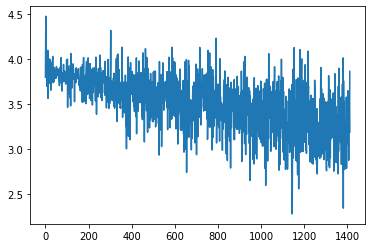

In [39]:
plt.plot(loss_list)
plt.show()